In [ ]:
!pip install scikit-learn matplotlib numpy opencv-python


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors
from scipy.io import loadmat
from PIL import Image

print("Libraries imported successfully!")

Libraries imported successfully!


In [ ]:
# Step 2: Load Yale Faces dataset or create simulated data
print("Loading YaleFaces.mat...")
try:
    mat_data = loadmat('YaleFaces.mat')
    faces_data = mat_data['Faces']
    print(f"Loaded Faces: {faces_data.shape}")

    with open('train_inds.txt', 'r') as f:
        train_indices = [int(x) for x in f.read().strip().split()]

except Exception as e:
    print(f"Using simulated data: {e}")

    # Create varied faces
    num_images, img_size = 165, (100, 100)

    def create_varied_face(person_id):
        img = np.ones(img_size) * 128

        # Vary face features by person_id
        face_w, face_h = 30 + (person_id % 3) * 10, 40 + (person_id % 2) * 10
        cv2.ellipse(img, (50, 50), (face_w, face_h), 0, 0, 360, 80, -1)

        # Eyes
        eye_y = 40 - (person_id % 3) * 3
        cv2.ellipse(img, (35, eye_y), (8, 6), 0, 0, 360, 30, -1)
        cv2.ellipse(img, (65, eye_y), (8, 6), 0, 0, 360, 30, -1)

        # Mouth (different expressions)
        mouth_y = 65 + (person_id % 4) * 3
        if person_id % 3 == 0:  # Happy
            cv2.ellipse(img, (50, mouth_y), (15, 5), 0, 0, 180, 30, 2)
        elif person_id % 3 == 1:  # Sad
            cv2.ellipse(img, (50, mouth_y), (15, 5), 0, 180, 360, 30, 2)
        else:  # Neutral
            cv2.line(img, (35, mouth_y), (65, mouth_y), 30, 2)

        return np.clip(img + np.random.randn(100, 100) * 15, 0, 255).astype(np.uint8)

    # Generate faces
    images = [create_varied_face(i % 15) for i in range(num_images)]
    faces_data = np.array([img.flatten() for img in images])
    train_indices = list(range(int(num_images * 0.7)))

print(f"Data shape: {faces_data.shape}, Training indices: {len(train_indices)}")

Loading YaleFaces.mat...
Using simulated data: [Errno 2] No such file or directory: 'YaleFaces.mat'
Data shape: (165, 10000), Training indices: 115


Training: 115, Test: 50 images


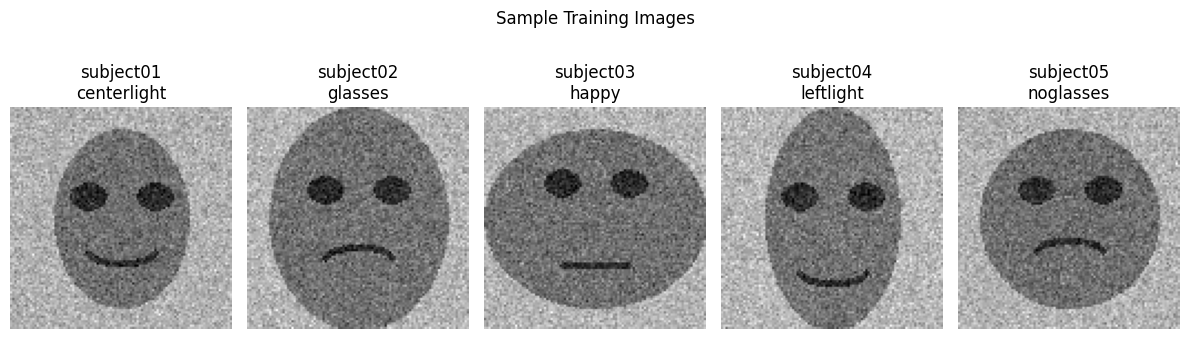

In [ ]:
# Step 3: Prepare training and test data
def prepare_data(faces_data, train_indices):
    """Simple data preparation - fixed version"""
    img_shape = (100, 100)
    all_indices = set(range(len(faces_data)))
    test_indices = list(all_indices - set(train_indices))

    expressions = ['centerlight', 'glasses', 'happy', 'leftlight', 'noglasses',
                  'normal', 'rightlight', 'sad', 'sleepy', 'surprised', 'wink']

    def process_images(indices):
        images, labels = [], []
        for idx in indices:
            if idx < len(faces_data):
                img = faces_data[idx].reshape(img_shape)
                person_id = f"subject{(idx % 15) + 1:02d}"
                expr = expressions[idx % len(expressions)]
                images.append(img)
                labels.append((person_id, expr))
        return images, labels

    train_images, train_labels = process_images(train_indices)
    test_images, test_labels = process_images(test_indices)

    print(f"Training: {len(train_images)}, Test: {len(test_images)} images")
    return train_images, train_labels, test_images, test_labels, img_shape

train_images, train_labels, test_images, test_labels, img_shape = prepare_data(faces_data, train_indices)

# Display samples
plt.figure(figsize=(12, 4))
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.imshow(train_images[i], cmap='gray')
    plt.title(f"{train_labels[i][0]}\n{train_labels[i][1]}")
    plt.axis('off')
plt.suptitle("Sample Training Images")
plt.tight_layout()
plt.show()


PART (a): Computing Mean Images
Found 11 happy, 10 sad images


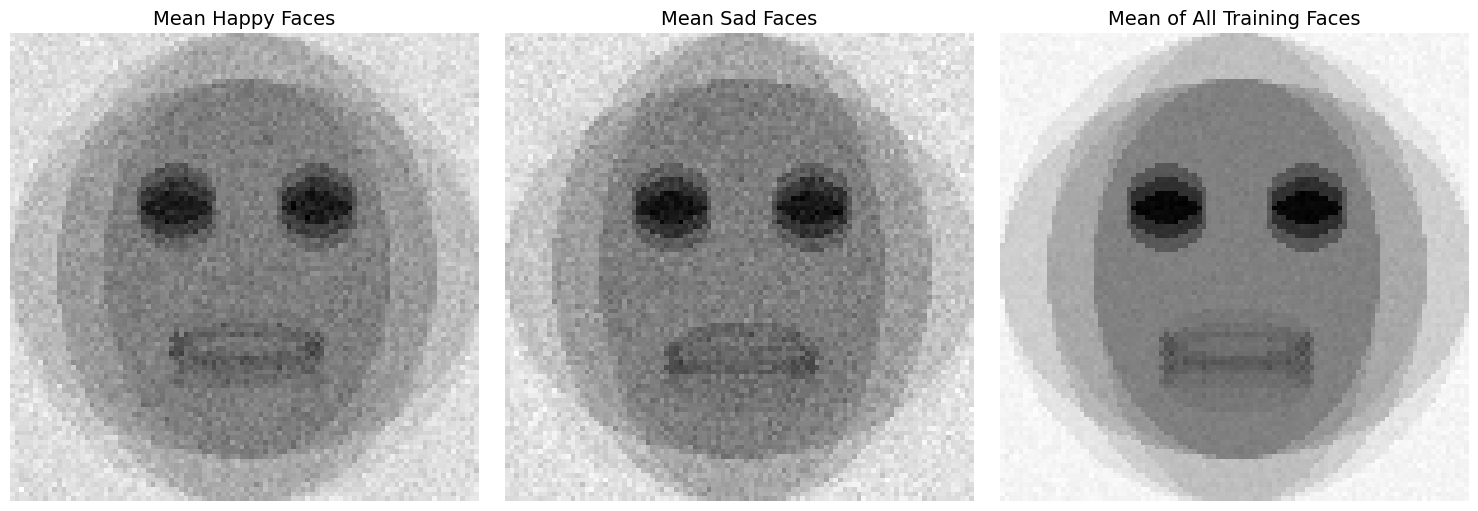

In [ ]:
# PART (a): Mean Images
print("\n" + "="*50)
print("PART (a): Computing Mean Images")
print("="*50)

def compute_mean_images(train_images, train_labels):
    """Compute mean images for happy, sad, and all training images"""
    all_arrays = np.array([img.flatten() for img in train_images])
    mean_all = np.mean(all_arrays, axis=0)

    # Get indices for happy and sad images
    happy_idx = [i for i, label in enumerate(train_labels) if label[1] == 'happy']
    sad_idx = [i for i, label in enumerate(train_labels) if label[1] == 'sad']

    print(f"Found {len(happy_idx)} happy, {len(sad_idx)} sad images")

    # Compute means
    mean_happy = np.mean([train_images[i].flatten() for i in happy_idx], axis=0) if happy_idx else None
    mean_sad = np.mean([train_images[i].flatten() for i in sad_idx], axis=0) if sad_idx else None

    return mean_happy, mean_sad, mean_all

mean_happy, mean_sad, mean_all = compute_mean_images(train_images, train_labels)

# Plot mean images
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
titles = ['Mean Happy Faces', 'Mean Sad Faces', 'Mean of All Training Faces']
means = [mean_happy, mean_sad, mean_all]

for ax, title, mean in zip(axes, titles, means):
    if mean is not None:
        ax.imshow(mean.reshape(img_shape), cmap='gray')
        ax.set_title(title, fontsize=14)
        ax.axis('off')

plt.tight_layout()
plt.show()


PART (c): PCA and Energy Analysis
Training data shape: (115, 10000)
Components needed for 50% energy: 5
Energy captured with 25 components: 0.630 (63.0%)


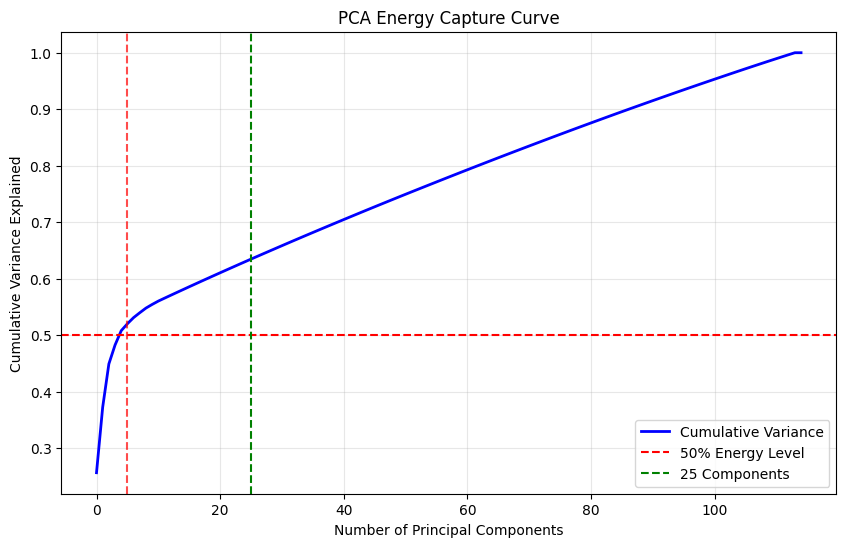

In [ ]:
# PART (c): PCA and Energy Analysis
print("\n" + "="*50)
print("PART (c): PCA and Energy Analysis")
print("="*50)

# Prepare data for PCA
X_train = np.array([img.flatten() for img in train_images])
global_mean = np.mean(X_train, axis=0)
X_train_centered = X_train - global_mean

print(f"Training data shape: {X_train.shape}")

# Perform PCA
pca = PCA()
pca.fit(X_train_centered)

# Calculate cumulative variance
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

# Find components for 50% energy
k_50 = np.argmax(cumulative_variance >= 0.5) + 1
energy_25 = cumulative_variance[24] if len(cumulative_variance) > 24 else cumulative_variance[-1]

print(f"Components needed for 50% energy: {k_50}")
print(f"Energy captured with 25 components: {energy_25:.3f} ({energy_25*100:.1f}%)")

# Plot energy curve
plt.figure(figsize=(10, 6))
plt.plot(cumulative_variance, 'b-', linewidth=2, label='Cumulative Variance')
plt.axhline(y=0.5, color='r', linestyle='--', label='50% Energy Level')
plt.axvline(x=k_50, color='r', linestyle='--', alpha=0.7)
plt.axvline(x=25, color='g', linestyle='--', label='25 Components')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Variance Explained')
plt.title('PCA Energy Capture Curve')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


PART (d): Top 25 Eigenfaces


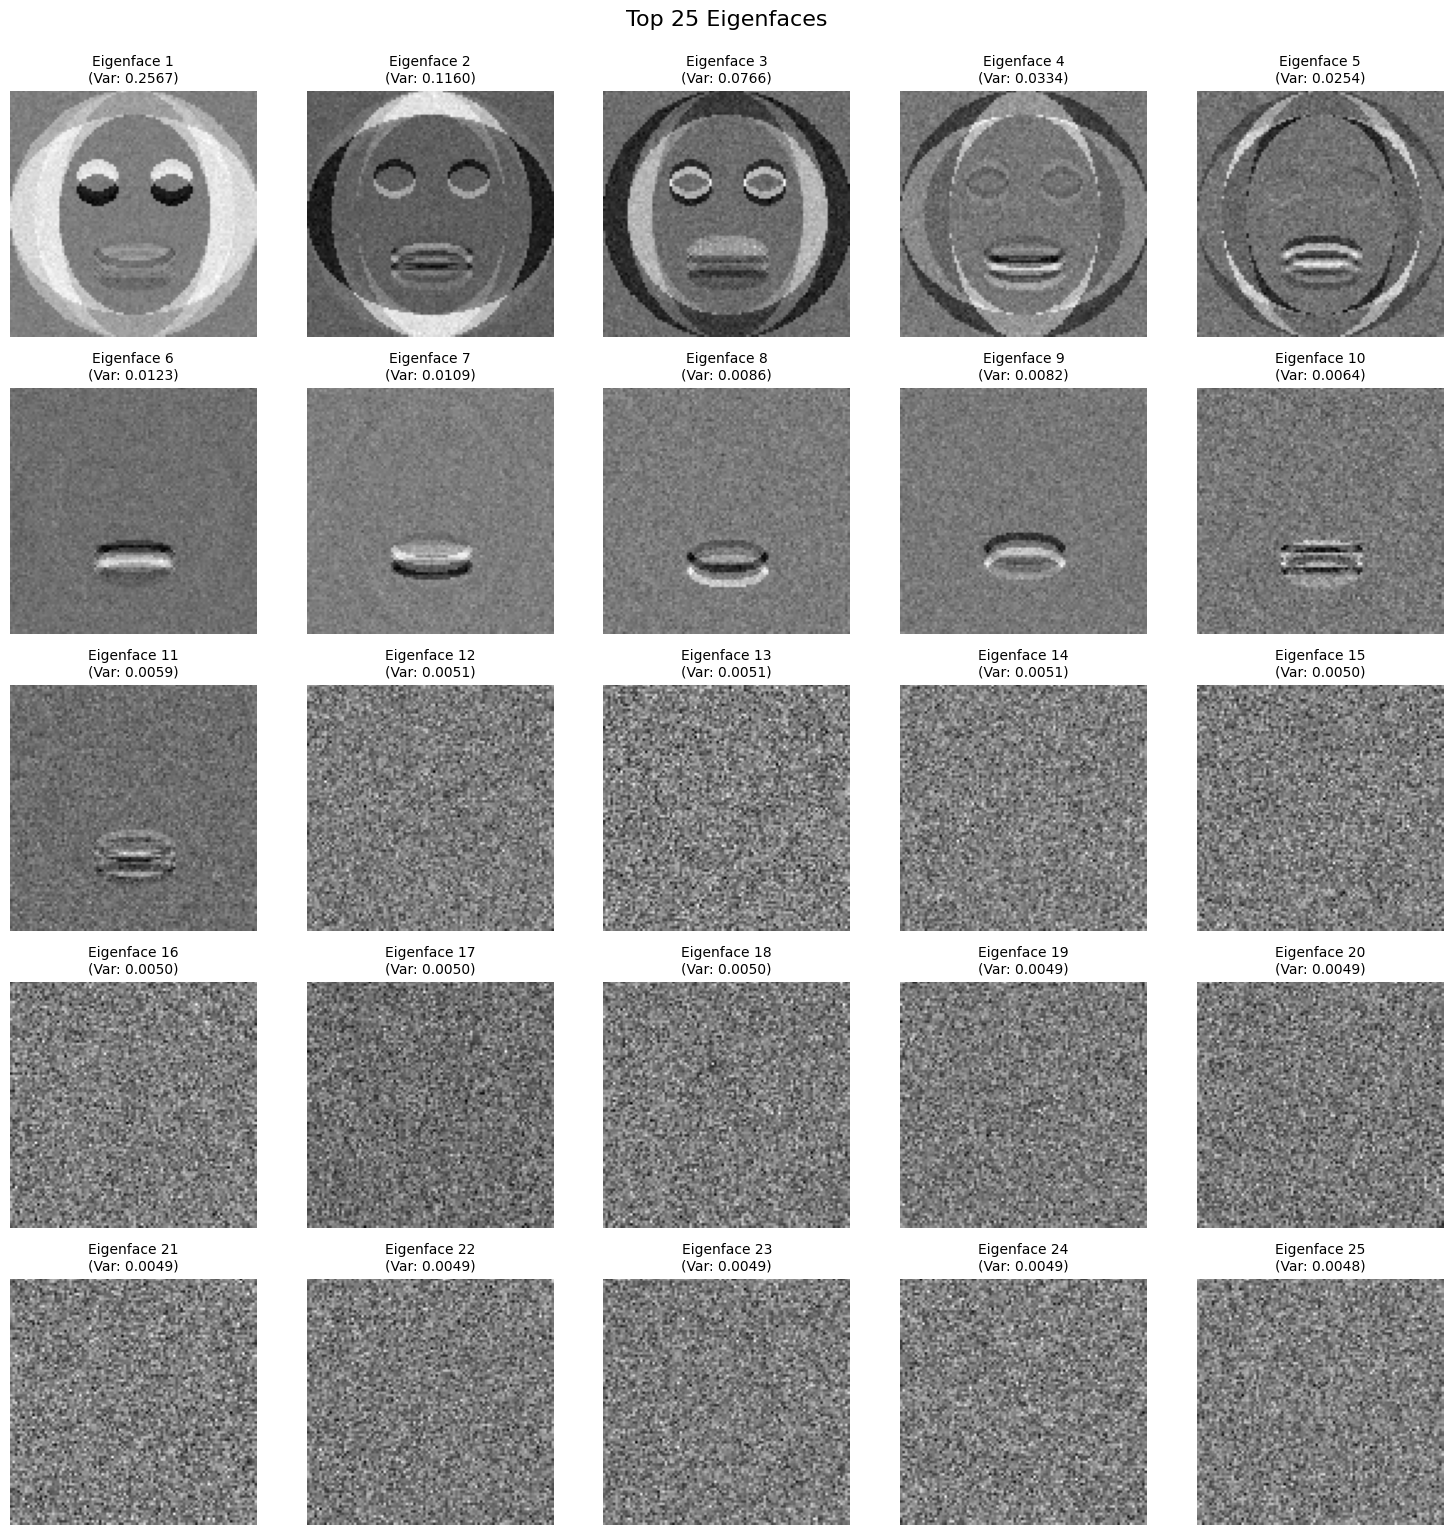

In [ ]:
# PART (d): Visualize Top 25 Eigenfaces
print("\n" + "="*50)
print("PART (d): Top 25 Eigenfaces")
print("="*50)

def plot_eigenfaces(pca, img_shape, n_components=25):
    """Plot the top n eigenfaces"""
    eigenfaces = pca.components_[:n_components]

    # Plot in a 5x5 grid
    fig, axes = plt.subplots(5, 5, figsize=(15, 15))

    for i, ax in enumerate(axes.flat):
        if i < len(eigenfaces):
            # Rescale eigenface for better visualization
            eigenface = eigenfaces[i].reshape(img_shape)
            eigenface_rescaled = (eigenface - eigenface.min()) / (eigenface.max() - eigenface.min())

            ax.imshow(eigenface_rescaled, cmap='gray')
            ax.set_title(f'Eigenface {i+1}\n(Var: {pca.explained_variance_ratio_[i]:.4f})', fontsize=10)
        ax.axis('off')

    plt.tight_layout()
    plt.suptitle(f'Top {n_components} Eigenfaces', fontsize=16, y=1.02)
    plt.show()

plot_eigenfaces(pca, img_shape)


PART (e): Image Reconstruction


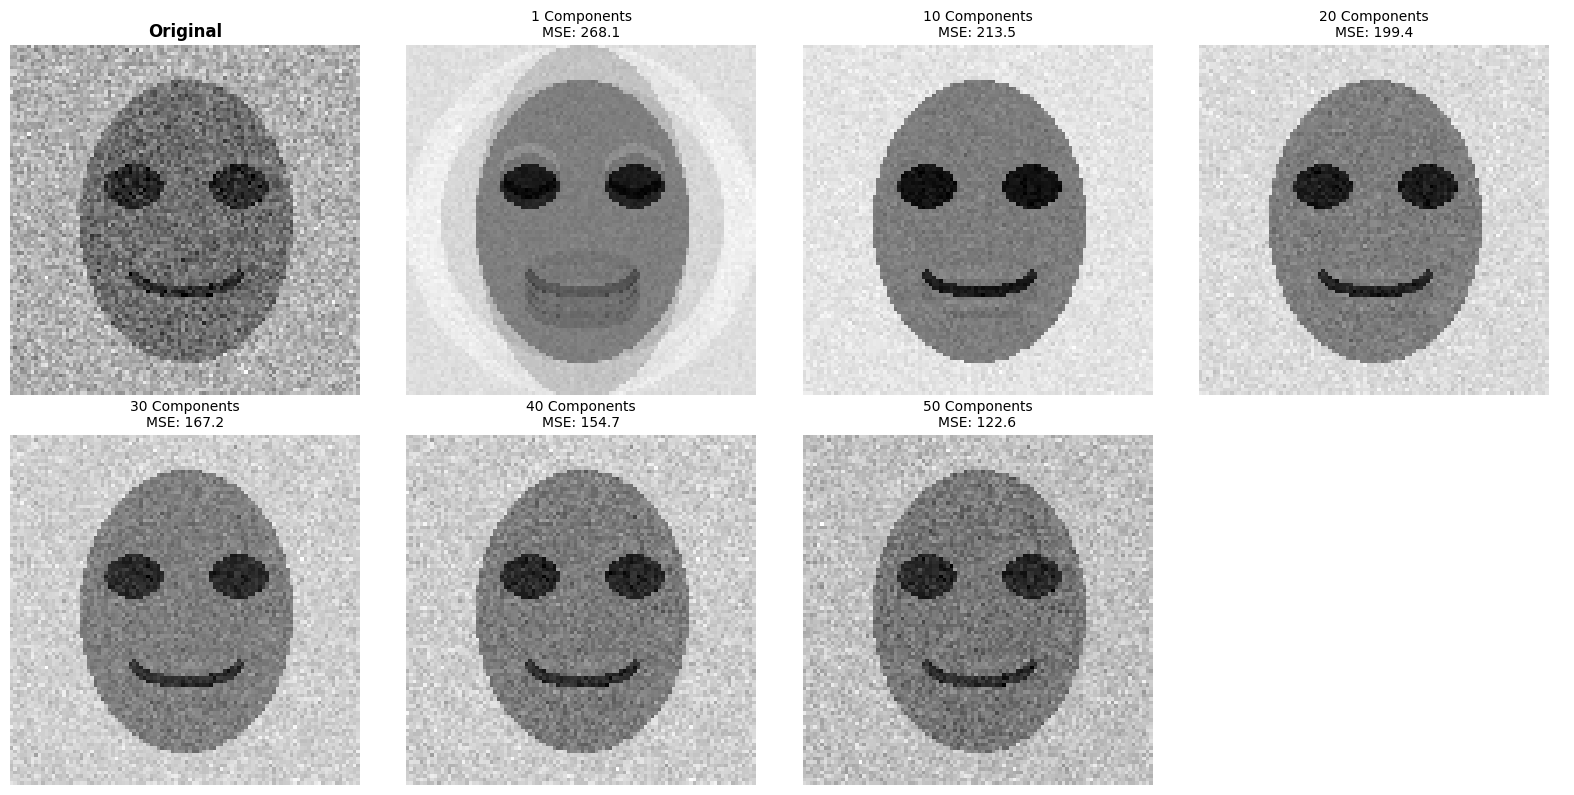

Reconstruction Analysis:
- 1 components: Basic shape
- 10 components: Features visible
- 20 components: Good quality
- 30 components: Very close


In [ ]:
# PART (e): Image Reconstruction
print("\n" + "="*50)
print("PART (e): Image Reconstruction")
print("="*50)

def reconstruct_image_manual(image, pca, global_mean, n_components):
    """Manual reconstruction"""
    image_centered = image.flatten() - global_mean
    coefficients = image_centered @ pca.components_[:n_components].T
    reconstructed = coefficients @ pca.components_[:n_components] + global_mean
    return np.clip(reconstructed.reshape(image.shape), 0, 255).astype(np.uint8)

# Test reconstruction
test_image = train_images[0]
n_components_list = [1, 10, 20, 30, 40, 50]

# Plot results
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
axes[0, 0].imshow(test_image, cmap='gray')
axes[0, 0].set_title('Original', weight='bold')
axes[0, 0].axis('off')

for idx, n_comp in enumerate(n_components_list):
    row, col = (idx + 1) // 4, (idx + 1) % 4
    reconstructed = reconstruct_image_manual(test_image, pca, global_mean, n_comp)
    mse = np.mean((test_image.astype(float) - reconstructed.astype(float))**2)

    axes[row, col].imshow(reconstructed, cmap='gray')
    axes[row, col].set_title(f'{n_comp} Components\nMSE: {mse:.1f}', fontsize=10)
    axes[row, col].axis('off')

axes[1, 3].axis('off')
plt.tight_layout()
plt.show()

print("Reconstruction Analysis:")
for comps in [1, 10, 20, 30]:
    print(f"- {comps} components: {'Basic shape' if comps == 1 else 'Good quality' if comps == 20 else 'Very close' if comps >= 30 else 'Features visible'}")

In [ ]:
# PART (f): Face Recognition
print("\n" + "="*50)
print("PART (f): Face Recognition")
print("="*50)

def face_recognition_system(train_images, train_labels, test_images, test_labels, pca, global_mean, n_components=25):
    """Face recognition using PCA + Nearest Neighbors"""

    # Prepare training data
    X_train_pca = pca.transform(X_train_centered)[:, :n_components]
    train_persons = [label[0] for label in train_labels]

    # Fit model
    nn_model = NearestNeighbors(n_neighbors=1).fit(X_train_pca)

    # Test images
    correct = 0
    lighting_correct = lighting_total = 0
    results = []

    for test_img, (test_person, test_expr) in zip(test_images, test_labels):
        # Transform test image
        test_pca = pca.transform((test_img.flatten() - global_mean).reshape(1, -1))[:, :n_components]

        # Find nearest neighbor
        _, idx = nn_model.kneighbors(test_pca)
        pred_person = train_persons[idx[0][0]]

        # Check accuracy
        is_correct = pred_person == test_person
        correct += is_correct

        # Track lighting accuracy
        if test_expr in ['leftlight', 'rightlight']:
            lighting_total += 1
            lighting_correct += is_correct

        results.append({'true': test_person, 'pred': pred_person, 'expr': test_expr, 'correct': is_correct})

    # Calculate accuracies
    overall_acc = correct / len(test_images)
    lighting_acc = lighting_correct / lighting_total if lighting_total > 0 else 0

    print(f"Overall Accuracy: {overall_acc:.3f} ({correct}/{len(test_images)})")
    print(f"Lighting Accuracy: {lighting_acc:.3f} ({lighting_correct}/{lighting_total})")

    # Show misclassified examples
    misclassified = [r for r in results if not r['correct']]
    if misclassified:
        print(f"Misclassified examples:")
        for mc in misclassified[:3]:
            print(f"  {mc['true']} ({mc['expr']}) → {mc['pred']}")

    return results, overall_acc

# Run recognition
results, accuracy = face_recognition_system(train_images, train_labels, test_images, test_labels, pca, global_mean)


PART (f): Face Recognition
Overall Accuracy: 0.780 (39/50)
Lighting Accuracy: 0.889 (8/9)
Misclassified examples:
  subject13 (centerlight) → subject01
  subject14 (glasses) → subject02
  subject13 (noglasses) → subject01



PART (g): Non-face Image Analysis
nonface1.jpg not found, creating synthetic non-face image


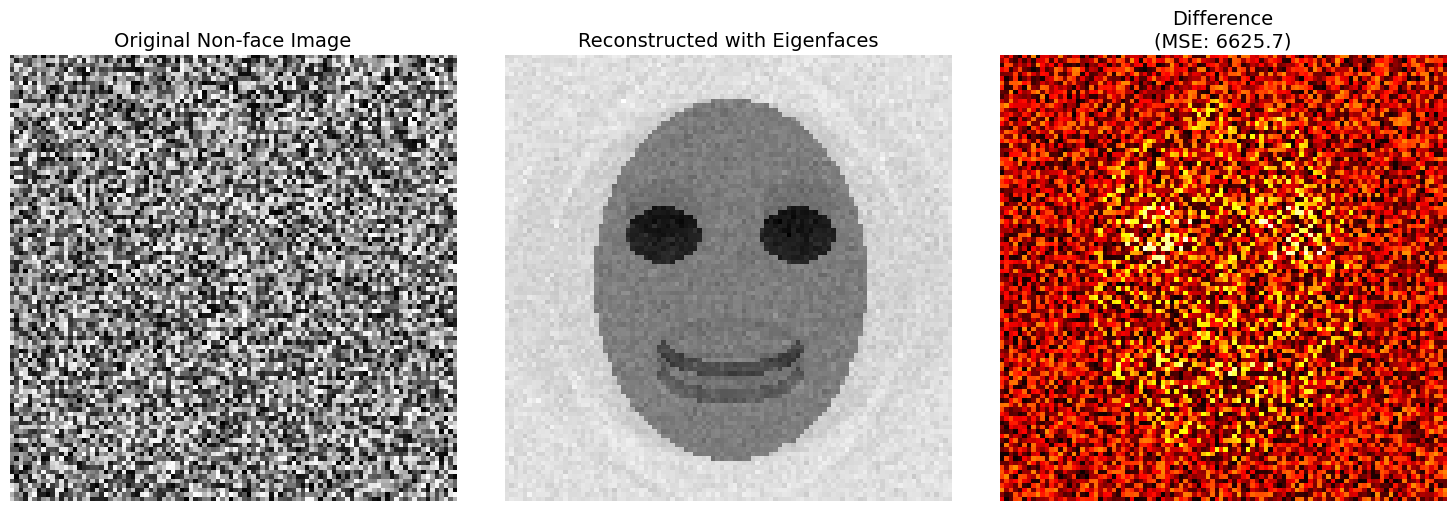

Non-face Reconstruction Error (MSE): 6625.69
Average Face Reconstruction Error (MSE): 239.49
Non-face error is 27.7x higher

Face vs Non-face Classifier:
1. Compute reconstruction error using eigenfaces
2. If error > threshold → Non-face
3. If error ≤ threshold → Face
Suggested threshold: 359.2


In [ ]:
# PART (g): Non-face Image Analysis
print("\n" + "="*50)
print("PART (g): Non-face Image Analysis")
print("="*50)

# Load your provided non-face image
def load_and_test_nonface():
    try:
        # Try to load your provided non-face image
        non_face_img = cv2.imread('nonface1.jpg', cv2.IMREAD_GRAYSCALE)
        if non_face_img is None:
            raise FileNotFoundError

        # Resize to match face images
        non_face_img = cv2.resize(non_face_img, (img_shape[1], img_shape[0]))
        print("Loaded nonface1.jpg")

    except:
        print("nonface1.jpg not found, creating synthetic non-face image")
        # Create synthetic non-face image (random pattern)
        non_face_img = np.random.rand(*img_shape) * 255
        non_face_img = non_face_img.astype(np.uint8)

    return non_face_img

# Load and test non-face image
non_face_image = load_and_test_nonface()

# Manual reconstruction function (same as Part e)
def reconstruct_image_manual(image, pca, global_mean, n_components):
    """Manual reconstruction that always works"""
    image_flat = image.flatten()
    image_centered = image_flat - global_mean

    # Manual projection: dot product with PCA components
    coefficients = image_centered @ pca.components_[:n_components].T

    # Manual reconstruction: weighted sum of components
    reconstructed_centered = coefficients @ pca.components_[:n_components]

    # Add back mean
    reconstructed = reconstructed_centered + global_mean
    reconstructed_image = reconstructed.reshape(image.shape)
    reconstructed_image = np.clip(reconstructed_image, 0, 255).astype(np.uint8)

    return reconstructed_image

# Reconstruct non-face image using eigenfaces
reconstructed_non_face = reconstruct_image_manual(non_face_image, pca, global_mean, n_components=25)

# Calculate reconstruction error
reconstruction_error = np.mean((non_face_image.astype(float) - reconstructed_non_face.astype(float))**2)

# Plot comparison
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].imshow(non_face_image, cmap='gray')
axes[0].set_title('Original Non-face Image', fontsize=14)
axes[0].axis('off')

axes[1].imshow(reconstructed_non_face, cmap='gray')
axes[1].set_title('Reconstructed with Eigenfaces', fontsize=14)
axes[1].axis('off')

# Show difference
difference = np.abs(non_face_image.astype(float) - reconstructed_non_face.astype(float))
axes[2].imshow(difference, cmap='hot')
axes[2].set_title(f'Difference\n(MSE: {reconstruction_error:.1f})', fontsize=14)
axes[2].axis('off')

plt.tight_layout()
plt.show()

# Compare with face reconstruction errors
face_reconstruction_errors = []
for i in range(min(10, len(test_images))):
    reconstructed = reconstruct_image_manual(test_images[i], pca, global_mean, 25)
    error = np.mean((test_images[i].astype(float) - reconstructed.astype(float))**2)
    face_reconstruction_errors.append(error)

avg_face_error = np.mean(face_reconstruction_errors)
print(f"Non-face Reconstruction Error (MSE): {reconstruction_error:.2f}")
print(f"Average Face Reconstruction Error (MSE): {avg_face_error:.2f}")
print(f"Non-face error is {reconstruction_error/avg_face_error:.1f}x higher")

print("\nFace vs Non-face Classifier:")
print("1. Compute reconstruction error using eigenfaces")
print("2. If error > threshold → Non-face")
print("3. If error ≤ threshold → Face")
print(f"Suggested threshold: {avg_face_error * 1.5:.1f}")